https://satijalab.org/seurat/archive/v3.1/atacseq_integration_vignette.html![image.png](attachment:image.png)

https://satijalab.org/seurat/archive/v3.0/atacseq_integration_vignette.html

In [4]:
library(Seurat)
library(ggplot2)
library(patchwork)
data <- readRDS("../../data/mouse-skin/data_list.rds")
peaks <- data$Peaks
genes = data[['Gene Expression']]

In [3]:
str(data)

List of 2
 $ Peaks          :Formal class 'dgTMatrix' [package "Matrix"] with 6 slots
  .. ..@ i       : int [1:139669728] 23 34 42 53 55 62 94 103 114 126 ...
  .. ..@ j       : int [1:139669728] 0 0 0 0 0 0 0 0 0 0 ...
  .. ..@ Dim     : int [1:2] 344592 34774
  .. ..@ Dimnames:List of 2
  .. .. ..$ : chr [1:344592] "chrX:143482906-143483206" "chr6:3200976-3201276" "chr9:123461850-123462150" "chr1:56782095-56782395" ...
  .. .. ..$ : chr [1:34774] "R1.01.R2.01.R3.06.P1.55" "R1.01.R2.03.R3.68.P1.55" "R1.01.R2.05.R3.15.P1.53" "R1.01.R2.05.R3.40.P1.55" ...
  .. ..@ x       : num [1:139669728] 1 2 2 1 1 1 1 1 1 1 ...
  .. ..@ factors : list()
 $ Gene Expression:Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. ..@ i       : int [1:26092640] 96 192 572 824 1207 1635 1646 1810 1846 1881 ...
  .. ..@ p       : int [1:42949] 0 330 3638 3829 4042 5305 5693 6180 6700 7307 ...
  .. ..@ Dim     : int [1:2] 23296 42948
  .. ..@ Dimnames:List of 2
  .. .. ..$ : chr [1:23296] "0610007P1

`gencode.vM23.primary_assembly.annotation.gtf` http://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M23/gencode.vM23.primary_assembly.annotation.gtf.gz

source: [10x Mouse reference, mm10 (GENCODE vM23/Ensembl 98)](https://support.10xgenomics.com/single-cell-gene-expression/software/release-notes/build#mm10_2020A)

In [69]:
# create a gene activity matrix from the peak matrix and GTF, using chromosomes 1:22, X, and Y.
# Peaks that fall within gene bodies, or 2kb upstream of a gene, are considered
activity.matrix <- CreateGeneActivityMatrix(peak.matrix = peaks, 
                                            annotation.file = "/data/pinello/PROJECTS/2019_08_RNA_Acceleration/chen_nbt_2019/analysis_HC/Mus_musculus.GRCm38.97.gtf", 
    seq.levels = c(1:19, "X", "Y"), upstream = 2000, verbose = TRUE)

Warning message:
“CreateGeneActivityMatrix functionality is being moved to Signac. Equivalent functionality can be achieved via the Signac::GeneActivity function; for more information on Signac, please see https://github.com/timoast/Signac”


In [70]:
str(activity.matrix[rownames(activity.matrix) %in% genes.use,])

Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  ..@ i       : int [1:7648592] 1 3 5 9 13 17 22 28 34 46 ...
  ..@ p       : int [1:34775] 0 125 449 801 1298 1502 2035 2436 2763 3471 ...
  ..@ Dim     : int [1:2] 1762 34774
  ..@ Dimnames:List of 2
  .. ..$ : chr [1:1762] "Hmgcs1" "Dusp10" "Mxd1" "Ifrd1" ...
  .. ..$ : chr [1:34774] "R1.01.R2.01.R3.06.P1.55" "R1.01.R2.03.R3.68.P1.55" "R1.01.R2.05.R3.15.P1.53" "R1.01.R2.05.R3.40.P1.55" ...
  ..@ x       : num [1:7648592] 1 1 1 2 1 1 1 1 1 3 ...
  ..@ factors : list()


In [72]:
atac <- CreateSeuratObject(counts = peaks, assay = "ATAC", project = "10x_ATAC")
atac[["ACTIVITY"]] <- CreateAssayObject(counts = activity.matrix)

In [73]:
atac

An object of class Seurat 
367055 features across 34774 samples within 2 assays 
Active assay: ATAC (344592 features, 0 variable features)
 1 other assay present: ACTIVITY

In [74]:
head(atac@meta.data)

,orig.ident,nCount_ATAC,nFeature_ATAC,nCount_ACTIVITY,nFeature_ACTIVITY
,<fct>,<dbl>,<int>,<dbl>,<int>
R1.01.R2.01.R3.06.P1.55,10x_ATAC,1496,1476,1218,984
R1.01.R2.03.R3.68.P1.55,10x_ATAC,4959,4728,4161,2933
R1.01.R2.05.R3.15.P1.53,10x_ATAC,4970,4768,3980,2831
R1.01.R2.05.R3.40.P1.55,10x_ATAC,9268,8715,7428,4602
R1.01.R2.05.R3.49.P1.55,10x_ATAC,2422,2384,1945,1531
R1.01.R2.06.R3.14.P1.55,10x_ATAC,10096,9377,8076,4948


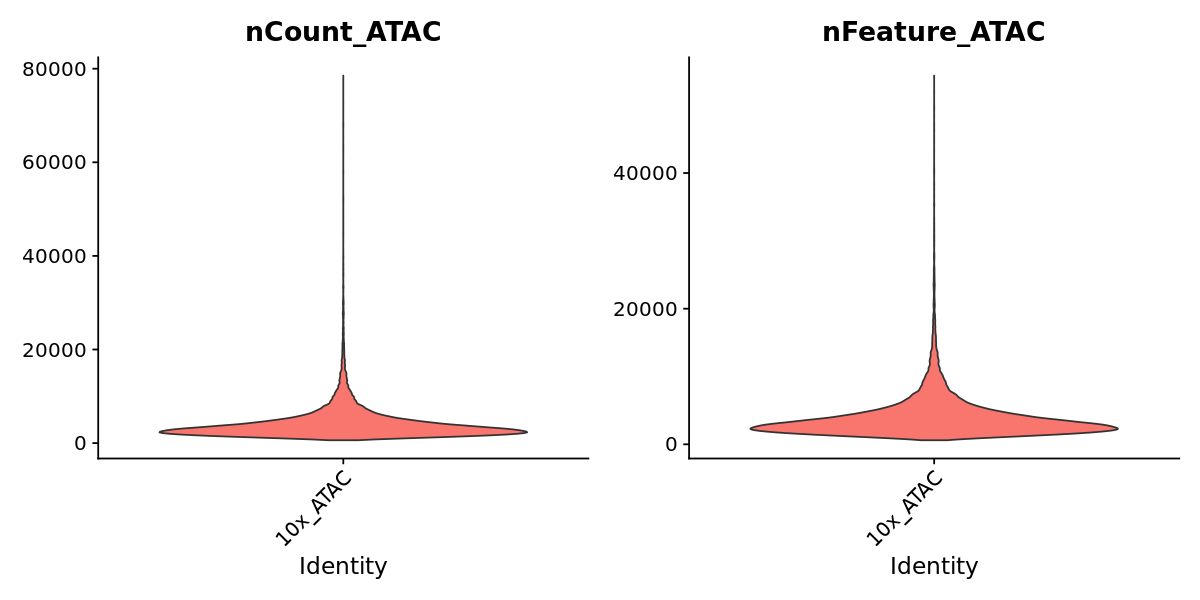

In [75]:
VlnPlot(
  object = atac,
  features = c("nCount_ATAC", "nFeature_ATAC"),
    ncol = 2,
  pt.size = 0
)

Warning message:
“Removed 303 rows containing non-finite values (stat_ydensity).”


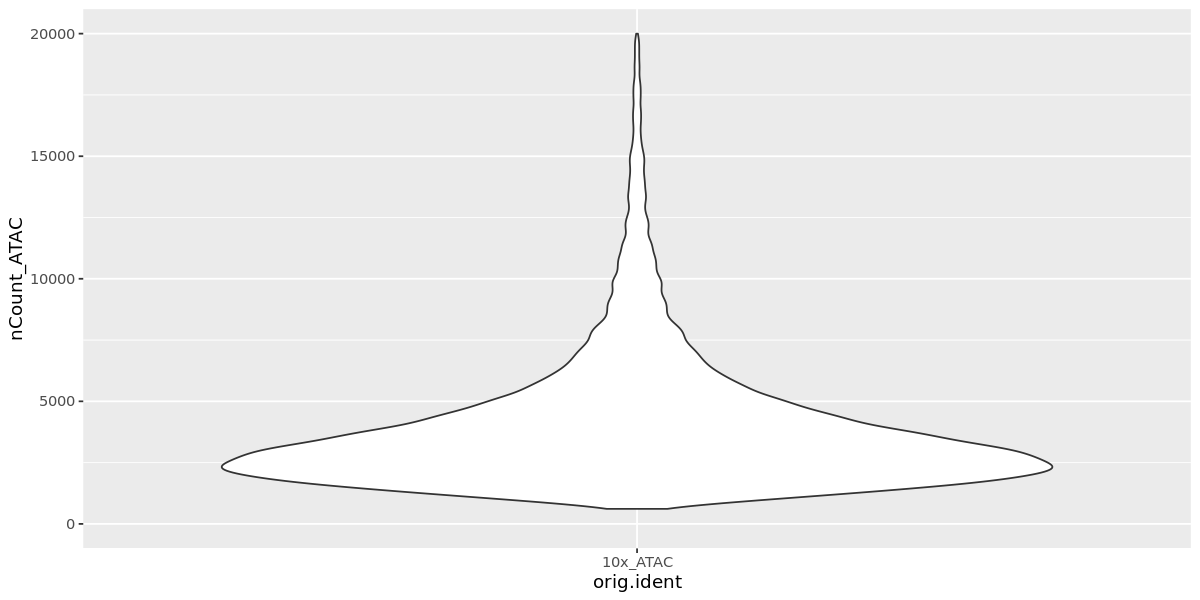

In [76]:
ggplot(atac@meta.data, aes(x = orig.ident, y = nCount_ATAC)) + geom_violin() + scale_y_continuous(limit = c(0, 2e4))

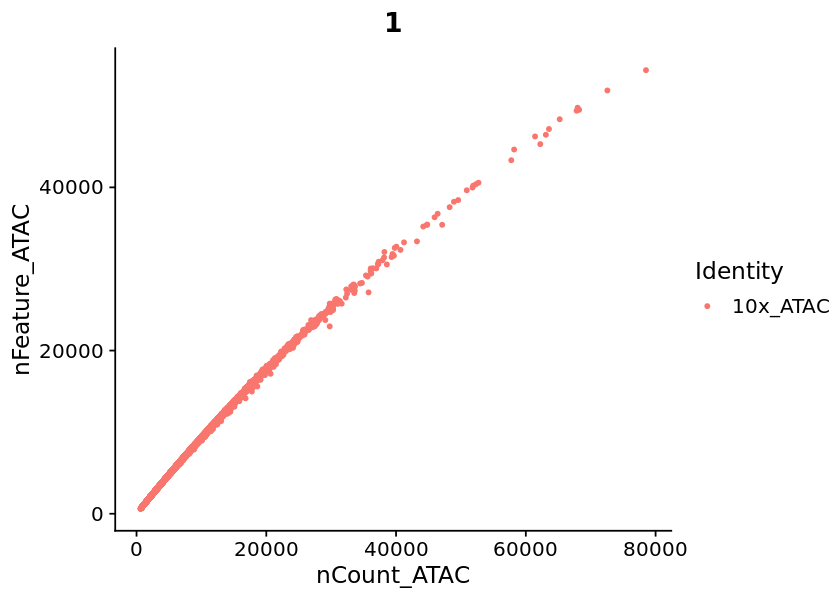

In [77]:
options(repr.plot.width = 7, repr.plot.height = 5)
FeatureScatter(atac, feature1 = "nCount_ATAC", feature2 = "nFeature_ATAC")

In [78]:
#atac <- subset(atac, subset = nCount_ATAC > 5000)
atac$tech <- "atac"

In [79]:
DefaultAssay(atac) <- "ACTIVITY"
atac <- FindVariableFeatures(atac)
atac <- NormalizeData(atac)
atac <- ScaleData(atac)

Centering and scaling data matrix



In [80]:
DefaultAssay(atac) <- "ATAC"
VariableFeatures(atac) <- names(which(Matrix::rowSums(atac) > 100))
atac <- RunLSI(atac, n = 50, scale.max = NULL)
atac <- RunUMAP(atac, reduction = "lsi", dims = 1:50)

Warning message:
“RunLSI is being moved to Signac. Equivalent functionality can be achieved via the Signac::RunTFIDF and Signac::RunSVD functions; for more information on Signac, please see https://github.com/timoast/Signac”
Warning message:
“RunLSI is being moved to Signac. Equivalent functionality can be achieved via the Signac::RunTFIDF and Signac::RunSVD functions; for more information on Signac, please see https://github.com/timoast/Signac”
Warning message:
“RunLSI is being moved to Signac. Equivalent functionality can be achieved via the Signac::RunTFIDF and Signac::RunSVD functions; for more information on Signac, please see https://github.com/timoast/Signac”
Performing TF-IDF normalization

Running SVD on TF-IDF matrix

Scaling cell embeddings

10:49:11 UMAP embedding parameters a = 0.9922 b = 1.112

10:49:11 Read 34774 rows and found 50 numeric columns

10:49:11 Using Annoy for neighbor search, n_neighbors = 30

10:49:11 Building Annoy index with metric = cosine, n_trees = 50


In [81]:
saveRDS(atac, "atac.rds")

# Making RNA object

### QC & preprocessing

In [17]:
rna <- CreateSeuratObject(counts = genes, assay = "RNA", project = "10k_RNA", min.cells = 3, min.features = 200)
rna$tech <- "rna"

In [18]:
rna

An object of class Seurat 
21080 features across 34774 samples within 1 assay 
Active assay: RNA (21080 features, 0 variable features)

In [19]:
rna[["percent.mt"]] <- PercentageFeatureSet(rna, pattern = "^MT-")

In [20]:
head(rna@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,tech,percent.mt
,<fct>,<dbl>,<int>,<chr>,<dbl>
R1.01.R2.01.R3.06.P1.55,10k_RNA,711,330,rna,0
R1.01.R2.03.R3.68.P1.55,10k_RNA,1133,452,rna,0
R1.01.R2.05.R3.15.P1.53,10k_RNA,2126,816,rna,0
R1.01.R2.05.R3.40.P1.55,10k_RNA,1626,798,rna,0
R1.01.R2.05.R3.49.P1.55,10k_RNA,1169,479,rna,0
R1.01.R2.06.R3.14.P1.55,10k_RNA,2757,1201,rna,0


Warning message in SingleExIPlot(type = type, data = data[, x, drop = FALSE], idents = idents, :
“All cells have the same value of percent.mt.”


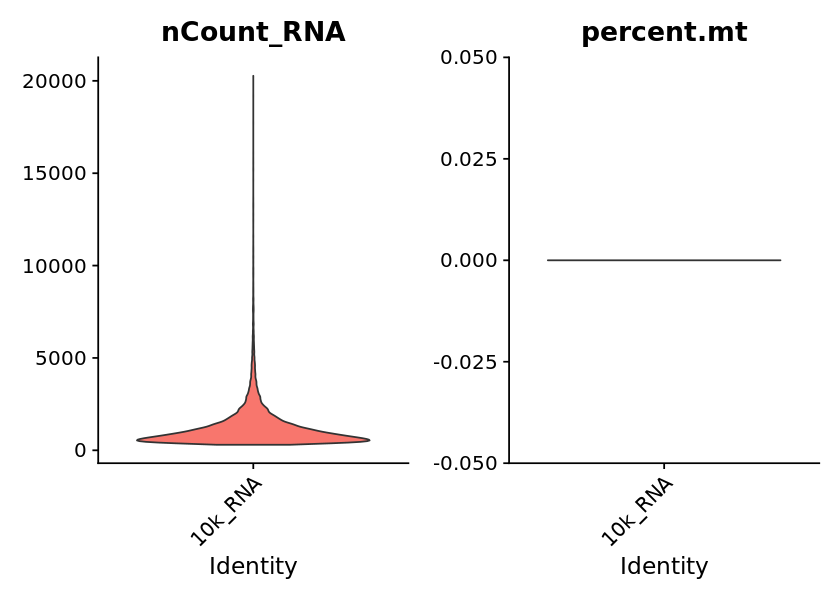

In [21]:
VlnPlot(
  object = rna,
  features = c("nCount_RNA", "percent.mt"),
    ncol = 2,
  pt.size = 0
)

Warning message in cor(x = data[, 1], y = data[, 2]):
“the standard deviation is zero”


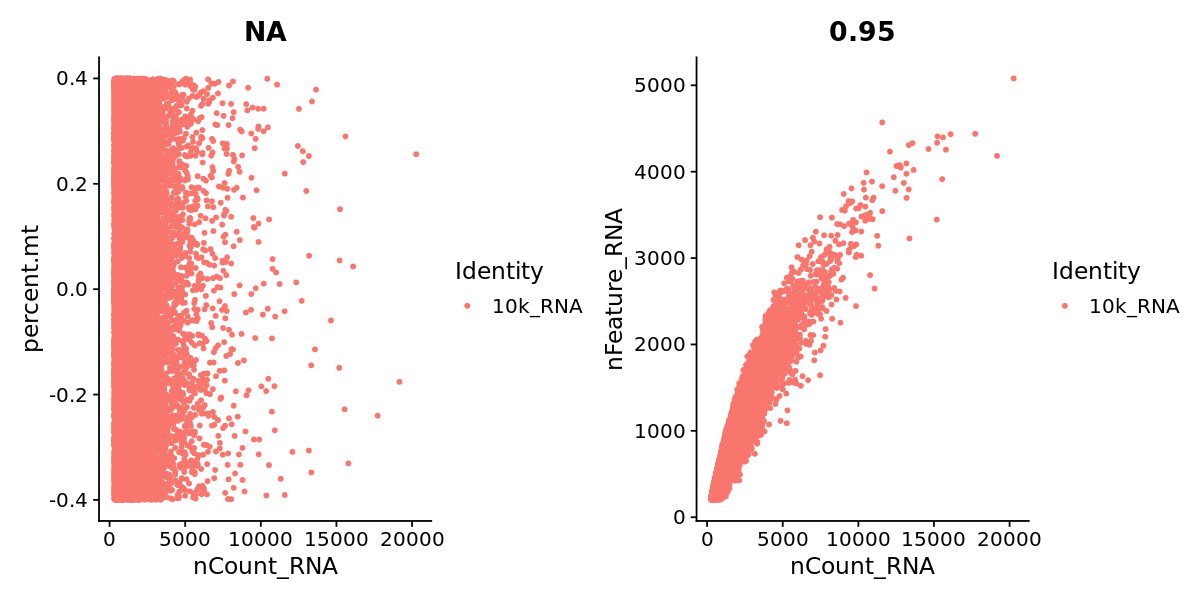

In [22]:
options(repr.plot.width = 10, repr.plot.height = 5)
plot1 <- FeatureScatter(rna, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(rna, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

In [28]:
summary(rna@meta.data$nFeature_RNA)
summary(rna@meta.data$nCount_RNA)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  201.0   343.0   506.0   642.6   785.0  5079.0 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    301     602     917    1259    1486   20272 

In [25]:
#rna <- subset(rna, subset = percent.mt < 20 & nCount_RNA < 25000 & nCount_RNA > 1000)
rna <- NormalizeData(rna, normalization.method = "LogNormalize", scale.factor = 10000)

In [26]:
rna <- FindVariableFeatures(rna, selection.method = "vst", nfeatures = 2000)

In [27]:
all.genes <- rownames(rna)
rna <- ScaleData(rna, features = all.genes)

Centering and scaling data matrix



In [29]:
# filter out low quality cells
#rna <- subset(
#  x = rna,
#  subset = nCount_RNA < 25000 &
#    nCount_RNA > 1000
#)
#rna

In [30]:
rna <- RunPCA(rna, features = VariableFeatures(object = rna))

PC_ 1 
Positive:  Ebf1, Sparc, Fbn1, Lama2, Col6a3, Zeb2, Col3a1, Col5a2, Fstl1, Fbxl7 
	   Prrx1, Meg3, Col4a1, Col1a2, Ldb2, Vim, Zeb1, Col5a1, Prex2, Grb10 
	   Zfp521, Col15a1, Col1a1, Nid1, Col4a2, Vcan, Pde3a, Thsd7a, Itpr1, Igfbp7 
Negative:  Clca3a2, Chl1, Dsg1a, Skint6, Serpinb2, Abca12, Skint5, Slc24a3, Il20ra, Krt77 
	   Sox6, Krt1, Sptlc3, Ipmk, Pkib, Krt10, Pof1b, Epgn, Fosl1, Lrp4 
	   Rgs20, Itga6, Fcgbp, Skint9, Ano9, P3h2, Scin, Tprg, Dmkn, Ifi202b 
PC_ 2 
Positive:  Ptprb, Cd36, Pecam1, Adgrf5, Flt1, Mecom, Adgrl4, Cdh5, Fabp4, Cyyr1 
	   Shank3, Dysf, Kdr, Cd93, Aqp1, Rasgrf2, Fli1, Ets1, Ptprm, Emcn 
	   Sdpr, Scarb1, Meox2, Prex2, Nrp1, Fgd5, Eng, Esam, Ldb2, Rasgrp3 
Negative:  Rspo2, Lama2, Vcan, Hhip, Corin, Dcc, Frem1, Rspo4, Col6a3, Nrg2 
	   Tmem132c, Col5a2, Cdh11, Prr16, Kcnq3, Ncam1, Prrx1, Col5a1, Fgf10, Lingo2 
	   Svep1, Masp1, Tbx15, Rspo3, Col3a1, Abca8a, Shisa9, Wif1, Nav3, Enpp2 
PC_ 3 
Positive:  Meg3, Col5a1, Col1a2, Fbn1, Ccdc80, Anxa1, Col1a1, C

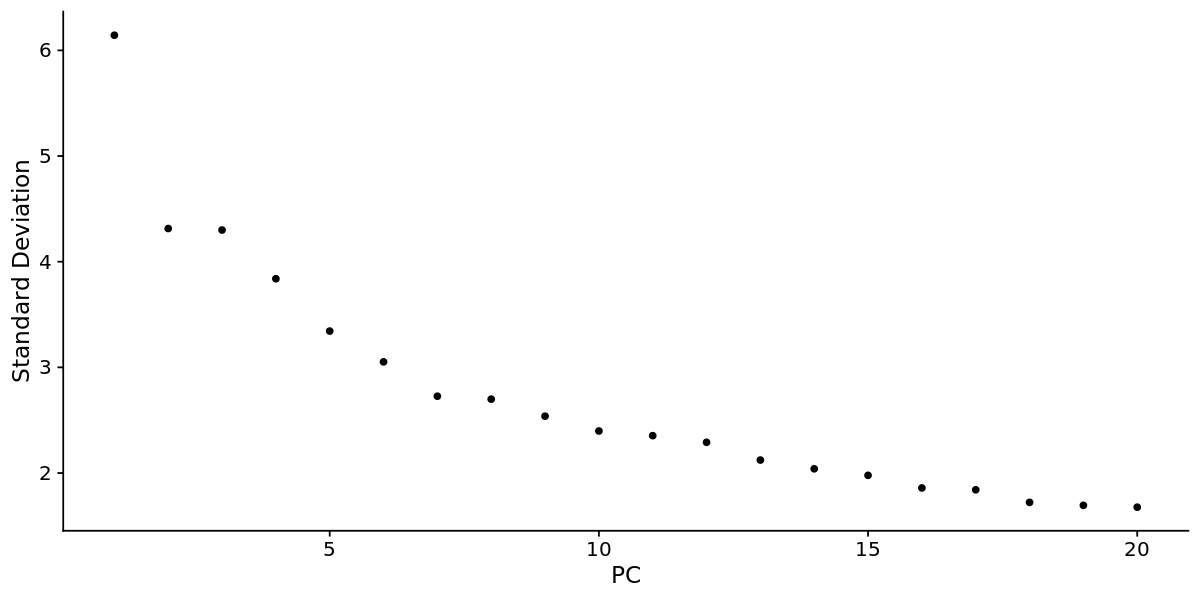

In [31]:
ElbowPlot(rna)

In [33]:
rna <- FindNeighbors(rna, dims = 1:20)
rna <- FindClusters(rna, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 34774
Number of edges: 1174186

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9136
Number of communities: 19
Elapsed time: 7 seconds


07:43:04 UMAP embedding parameters a = 0.9922 b = 1.112

07:43:04 Read 34774 rows and found 20 numeric columns

07:43:04 Using Annoy for neighbor search, n_neighbors = 30

07:43:04 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

07:43:08 Writing NN index file to temp file /tmp/RtmptIGccn/file3540e5813a222

07:43:08 Searching Annoy index using 1 thread, search_k = 3000

07:43:22 Annoy recall = 100%

07:43:23 Commencing smooth kNN distance calibration using 1 thread

07:43:26 Initializing from normalized Laplacian + noise

07:43:27 Commencing optimization for 200 epochs, with 1595694 positive edges

07:44:08 Optimization finished



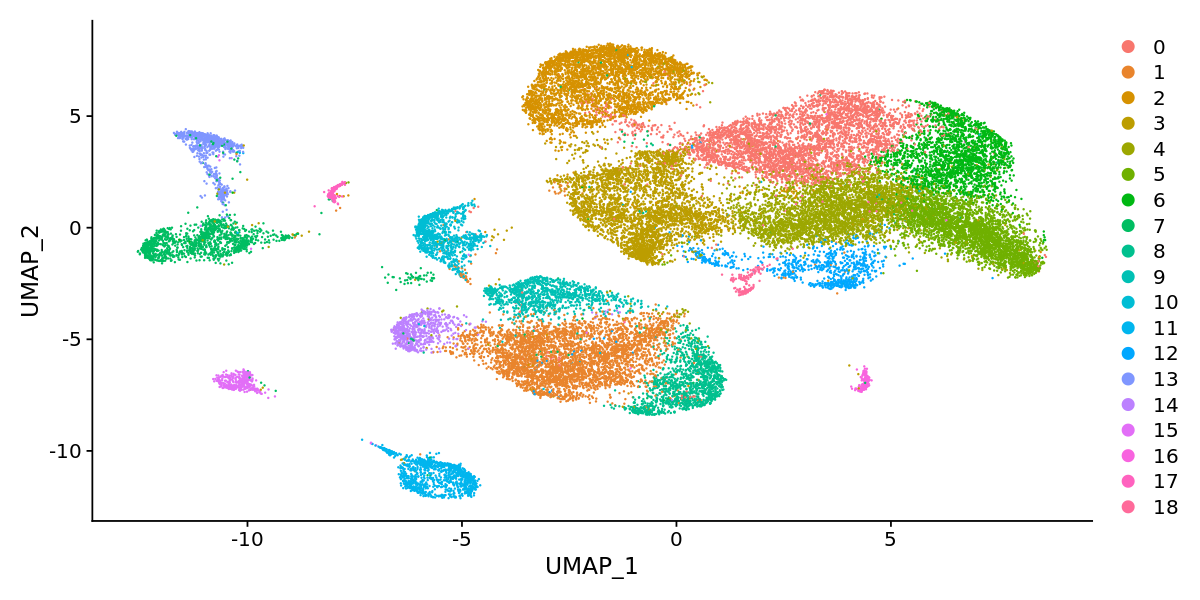

In [35]:
rna <- RunUMAP(rna, dims = 1:20)
DimPlot(rna, reduction = "umap")

In [36]:
saveRDS(rna, "rna.rds")

Warning message:
“CombinePlots is being deprecated. Plots should now be combined using the patchwork system.”


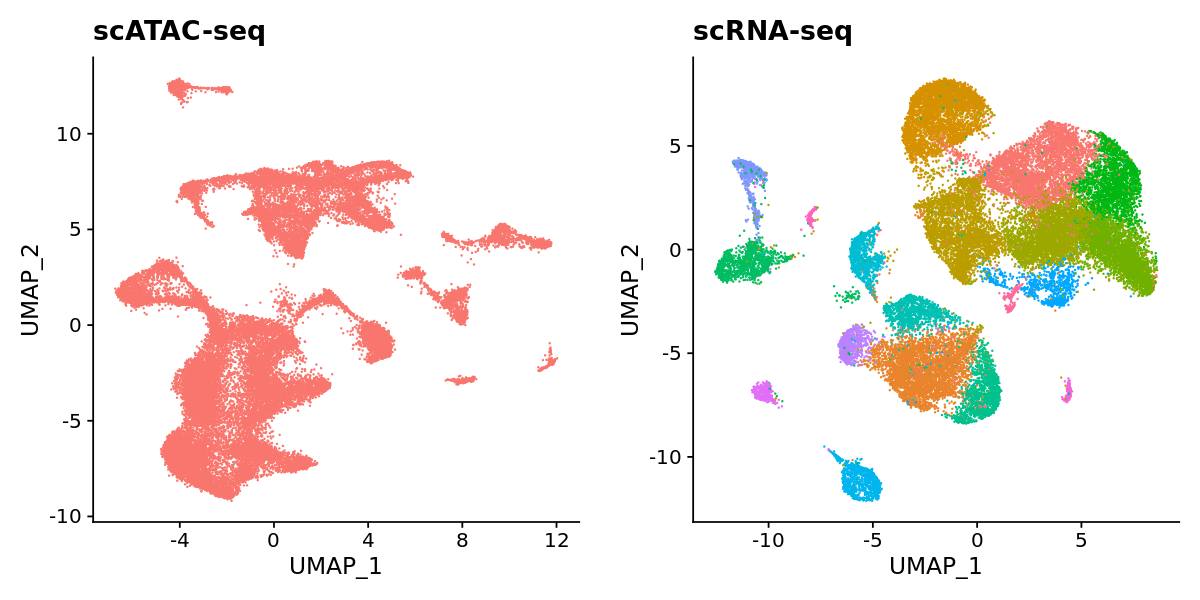

In [37]:
p1 <- DimPlot(atac, reduction = "umap") + NoLegend() + ggtitle("scATAC-seq")
p2 <- DimPlot(rna, reduction = "umap") + NoLegend() + ggtitle("scRNA-seq")
CombinePlots(plots = list(p1, p2))

# Co-embedding

In [82]:
shared_cells = intersect(colnames(x = rna[["RNA"]]), colnames(x = atac[["ATAC"]]))

In [83]:
length(shared_cells)

[1] 0

In [84]:
revert_cid <- function(str_v){
    sapply(strsplit(str_v, split = ".", fixed = TRUE), function(l) l[2])
}

In [85]:
rna <- RenameCells(rna, new.names =  paste0("rna.", colnames(x = rna[["RNA"]])))
atac <- RenameCells(atac, new.names = paste0("atac.", colnames(x = atac[["ATAC"]])))

In [86]:
rna; atac

An object of class Seurat 
21080 features across 34774 samples within 1 assay 
Active assay: RNA (21080 features, 2000 variable features)
 2 dimensional reductions calculated: pca, umap

An object of class Seurat 
367055 features across 34774 samples within 2 assays 
Active assay: ATAC (344592 features, 235325 variable features)
 1 other assay present: ACTIVITY
 2 dimensional reductions calculated: lsi, umap

In [87]:
str(atac)

Formal class 'Seurat' [package "Seurat"] with 13 slots
  ..@ assays      :List of 2
  .. ..$ ATAC    :Formal class 'Assay' [package "Seurat"] with 8 slots
  .. .. .. ..@ counts       :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. ..@ i       : int [1:139669728] 23 34 42 53 55 62 94 103 114 126 ...
  .. .. .. .. .. ..@ p       : int [1:34775] 0 1476 6204 10972 19687 22071 31448 37785 42524 57558 ...
  .. .. .. .. .. ..@ Dim     : int [1:2] 344592 34774
  .. .. .. .. .. ..@ Dimnames:List of 2
  .. .. .. .. .. .. ..$ : chr [1:344592] "chrX:143482906-143483206" "chr6:3200976-3201276" "chr9:123461850-123462150" "chr1:56782095-56782395" ...
  .. .. .. .. .. .. ..$ : chr [1:34774] "atac.R1.01.R2.01.R3.06.P1.55" "atac.R1.01.R2.03.R3.68.P1.55" "atac.R1.01.R2.05.R3.15.P1.53" "atac.R1.01.R2.05.R3.40.P1.55" ...
  .. .. .. .. .. ..@ x       : num [1:139669728] 1 2 2 1 1 1 1 1 1 1 ...
  .. .. .. .. .. ..@ factors : list()
  .. .. .. ..@ data         :Formal class 'dgCMatr

In [88]:
transfer.anchors <- FindTransferAnchors(reference = rna, query = atac, features = VariableFeatures(object = rna), 
    reference.assay = "RNA", query.assay = "ACTIVITY", reduction = "cca")

Warning message in RunCCA.Seurat(object1 = reference, object2 = query, features = features, :
“Running CCA on different assays”
Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 63198 anchors

Filtering anchors

	Retained 6001 anchors



In [89]:
str(atac)

Formal class 'Seurat' [package "Seurat"] with 13 slots
  ..@ assays      :List of 2
  .. ..$ ATAC    :Formal class 'Assay' [package "Seurat"] with 8 slots
  .. .. .. ..@ counts       :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. .. .. .. .. ..@ i       : int [1:139669728] 23 34 42 53 55 62 94 103 114 126 ...
  .. .. .. .. .. ..@ p       : int [1:34775] 0 1476 6204 10972 19687 22071 31448 37785 42524 57558 ...
  .. .. .. .. .. ..@ Dim     : int [1:2] 344592 34774
  .. .. .. .. .. ..@ Dimnames:List of 2
  .. .. .. .. .. .. ..$ : chr [1:344592] "chrX:143482906-143483206" "chr6:3200976-3201276" "chr9:123461850-123462150" "chr1:56782095-56782395" ...
  .. .. .. .. .. .. ..$ : chr [1:34774] "atac.R1.01.R2.01.R3.06.P1.55" "atac.R1.01.R2.03.R3.68.P1.55" "atac.R1.01.R2.05.R3.15.P1.53" "atac.R1.01.R2.05.R3.40.P1.55" ...
  .. .. .. .. .. ..@ x       : num [1:139669728] 1 2 2 1 1 1 1 1 1 1 ...
  .. .. .. .. .. ..@ factors : list()
  .. .. .. ..@ data         :Formal class 'dgCMatr

In [90]:
str(atac[["lsi"]])

Formal class 'DimReduc' [package "Seurat"] with 9 slots
  ..@ cell.embeddings           : num [1:34774, 1:50] -1.013 -1.054 -0.646 -0.94 -0.757 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:34774] "atac.R1.01.R2.01.R3.06.P1.55" "atac.R1.01.R2.03.R3.68.P1.55" "atac.R1.01.R2.05.R3.15.P1.53" "atac.R1.01.R2.05.R3.40.P1.55" ...
  .. .. ..$ : chr [1:50] "LSI_1" "LSI_2" "LSI_3" "LSI_4" ...
  ..@ feature.loadings          : num [1:235325, 1:50] -0.00481 -0.00502 -0.00483 -0.00482 -0.00473 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:235325] "chrX:143482906-143483206" "chr6:3200976-3201276" "chr9:123461850-123462150" "chr1:56782095-56782395" ...
  .. .. ..$ : chr [1:50] "LSI_1" "LSI_2" "LSI_3" "LSI_4" ...
  ..@ feature.loadings.projected: num[0 , 0 ] 
  ..@ assay.used                : chr "ATAC"
  ..@ global                    : logi FALSE
  ..@ stdev                     : num [1:50] 3.287 1.035 0.784 0.752 0.691 ...
  ..@ key                       : chr "LS

In [92]:
# note that we restrict the imputation to variable genes from scRNA-seq, but could impute the
# full transcriptome if we wanted to
genes.use <- VariableFeatures(rna)
refdata <- GetAssayData(rna, assay = "RNA", slot = "data")[genes.use, ]

# refdata (input) contains a scRNA-seq expression matrix for the scRNA-seq cells.  imputation
# (output) will contain an imputed scRNA-seq matrix for each of the ATAC cells
imputation <- TransferData(anchorset = transfer.anchors, refdata = refdata, weight.reduction = atac[["lsi"]])

# this line adds the imputed data matrix to the atac object
atac[["RNA"]] <- imputation
coembed <- merge(x = rna, y = atac)

# Finally, we run PCA and UMAP on this combined object, to visualize the co-embedding of both
# datasets
coembed <- ScaleData(coembed, features = genes.use, do.scale = FALSE)
coembed <- RunPCA(coembed, features = genes.use, verbose = FALSE)
coembed <- RunUMAP(coembed, dims = 1:30)
#coembed$celltype <- ifelse(!is.na(coembed$celltype), coembed$celltype, coembed$predicted.id)

Finding integration vectors

Finding integration vector weights

Transfering 2000 features onto reference data

Centering data matrix

11:59:43 UMAP embedding parameters a = 0.9922 b = 1.112

11:59:43 Read 69548 rows and found 30 numeric columns

11:59:43 Using Annoy for neighbor search, n_neighbors = 30

11:59:43 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

12:00:00 Writing NN index file to temp file /tmp/RtmptIGccn/file3540e5ed0ecca

12:00:00 Searching Annoy index using 1 thread, search_k = 3000

12:00:32 Annoy recall = 100%

12:00:33 Commencing smooth kNN distance calibration using 1 thread

12:00:37 Initializing from normalized Laplacian + noise

12:00:42 Commencing optimization for 200 epochs, with 3237400 positive edges

12:02:03 Optimization finished



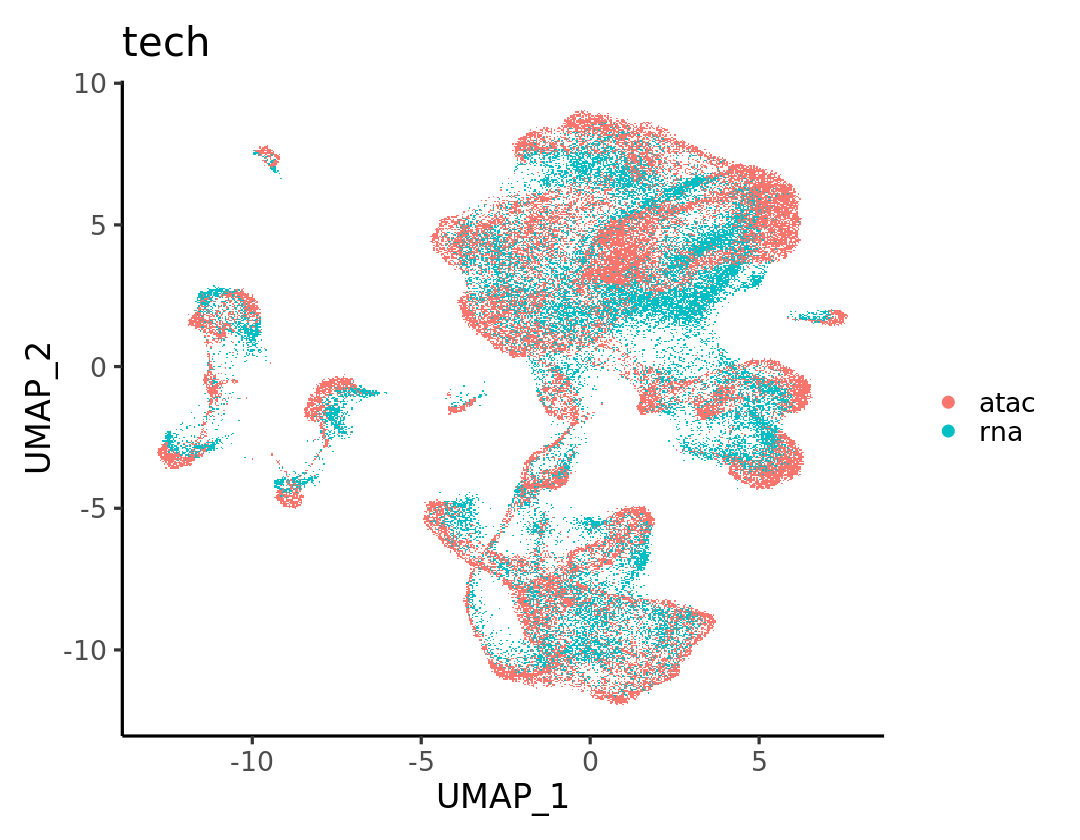

In [93]:
options(repr.plot.width = 9, repr.plot.height = 7)
DimPlot(coembed, group.by = "tech") + theme_classic(base_size = 20)

In [94]:
rna_cells = colnames(rna[['RNA']])
atac_cells = colnames(atac[["ATAC"]])

In [95]:
all(coembed[["ATAC"]][,rna_cells] == 0)
all_genes = rownames(coembed[['RNA']])
unused_genes = all_genes[! all_genes %in% genes.use]
all(coembed[["RNA"]][unused_genes,atac_cells] == 0)

[1] TRUE

[1] TRUE

In [96]:
imputed_gexp = coembed[['RNA']][genes.use,]
str(imputed_gexp)

Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  ..@ i       : int [1:32695430] 0 1 2 3 8 17 74 78 96 98 ...
  ..@ p       : int [1:69549] 0 89 185 364 547 649 853 937 1097 1418 ...
  ..@ Dim     : int [1:2] 2000 69548
  ..@ Dimnames:List of 2
  .. ..$ : chr [1:2000] "Tchh" "Col1a1" "Col3a1" "Col1a2" ...
  .. ..$ : chr [1:69548] "rna.rna.R1.01.R2.01.R3.06.P1.55" "rna.rna.R1.01.R2.03.R3.68.P1.55" "rna.rna.R1.01.R2.05.R3.15.P1.53" "rna.rna.R1.01.R2.05.R3.40.P1.55" ...
  ..@ x       : num [1:32695430] 2.71 4.27 2.71 3.37 2.71 ...
  ..@ factors : list()


In [45]:
saveRDS(coembed, "coembed.rds")

In [27]:
all(coembed[["RNA"]]@data[, rna_cells] == rna[["RNA"]]@data)

[1] TRUE

In [7]:
coembed <- readRDS("coembed.rds")

## Incorporate cell type

In [1]:
meta <- read.table("../../data/mouse-skin/GSM4156597_skin_celltype.txt", stringsAsFactors = F, head = T)

In [5]:
meta.ft = c(meta$celltype, meta$celltype)
names(meta.ft) = c(paste0("rna.", meta$rna.bc), paste0("atac.", meta$rna.bc))

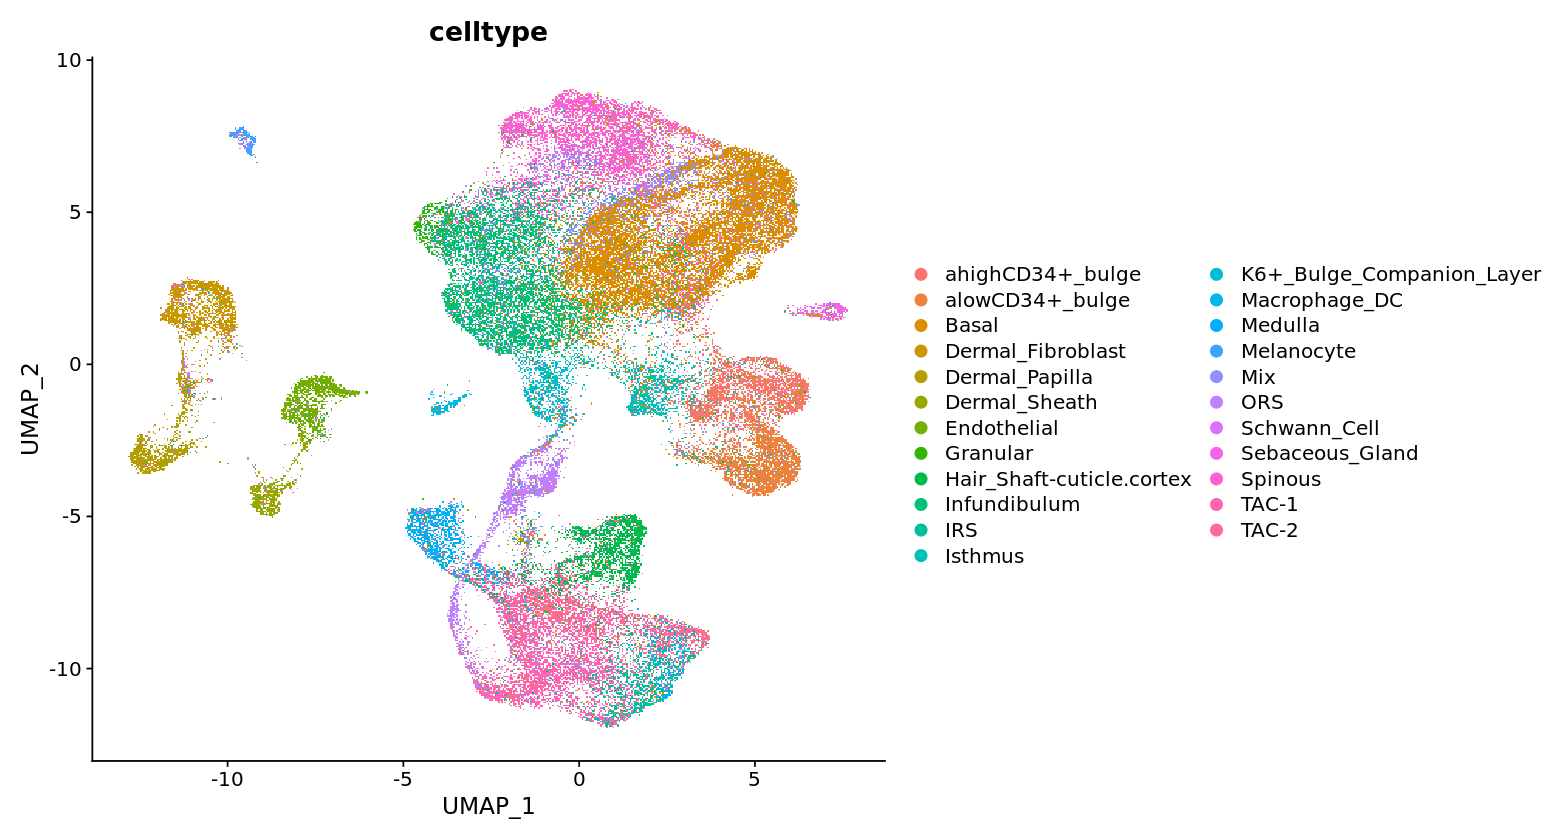

In [49]:
options(repr.plot.width = 13, repr.plot.height = 7)
coembed$celltype = meta.ft
DimPlot(coembed, group.by = "celltype")

In [53]:
embedding = as.data.frame(coembed@reductions$pca@cell.embeddings)
embedding$cell_type = factor(meta.ft[rownames(embedding)])

In [2]:
embedding <- read.table("integrated_embedding.txt")

In [10]:
embedding$batch = as.numeric(factor(sapply(strsplit(rownames(embedding), split = ".", fixed = T), function(s) paste0(s[2:length(s)], collapse = "."))))

In [12]:
write.table(embedding, "integrated_embedding.txt", quote = F, sep = "\t", row.names = T, col.names = T)